## Importações

<h4>Bibliotecas que foram utilizadas durante o desenvolvimento do código e seus objetivos:</h4>

- Sklearn : 
    
    Para avaliar o desempenho dos modelos utilizando a técnica do Cross Validation (model_selection)

    Encontrar o melhor conjunto de parametros para o modelo de acordo com as informações apresentadas (model_selection)

    Para captar os modelos (naive_bayes, neighbors)

- Pandas :
    
    Disponibiliza ferramentas para manipular DataFrames, como por exemplo a forma que são apresentadas as bases

- Pickle:
    
    É usado para extrair as bases do arquivo "bases.pk1" e para armazenar o modelo escolhido em um arquivo .pk1

- Numpy

    No contexto deste notebook, ele auxilia nos intervalos de números que são apresentados nos parametros dos modelos.

In [9]:
# Pandas
import pandas as pd

# Pickle
import pickle

# Numpy
import numpy as np

# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Melhoras Modelos

## Recuperação dos modelos

In [10]:
modelos_armazenados = pickle.load(open('./modelos_before.pk1','rb'))

## Teste Pipeline

### <h1 style='color:red'>FALTA TESTAR NORMALIZAÇÃO DE BASES VARIADAS</h1>

### Parametros Pipeline

In [11]:
parametros = {}

# Naive Bayes
parametros['naive_bayes'] = []

for i in range(1, 8):
     parametros['naive_bayes'].append({
        'scaler': [StandardScaler()],
        'SelectKBest__k': [i],
        'pca__n_components': [n for n in range(1, i+1)],
        'model' : [modelos_armazenados['naive_bayes'][0]['Modelo']]
    })

# Arvore - Tree
parametros['tree'] = []

for i in range(1, 8):
    parametros['tree'].append({
        'scaler': [StandardScaler()],
        'SelectKBest__k': [i],
        'pca__n_components': [n for n in range(1, i + 1)],
        'model' : [modelos_armazenados['tree'][0]['Modelo']]
    })

# KNN 
parametros['knn'] = []

for i in range(1, 8):
    parametros['knn'].append({
        'scaler': [StandardScaler()],
        'SelectKBest__k': [i],
        'pca__n_components': [n for n in range(1, i+1)],
        'model' : [modelos_armazenados['knn'][0]['Modelo']]
    })

## Pipeline

In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('pca', PCA()),
    ('model', DecisionTreeClassifier())
])

## Teste Pipeline

In [13]:
modelos_f1_pipe = {}
infos_pipe = {}

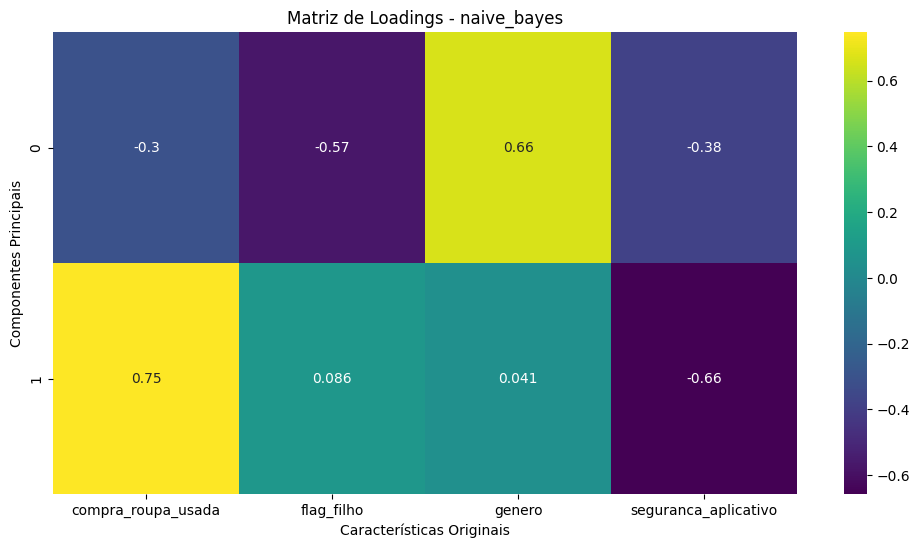

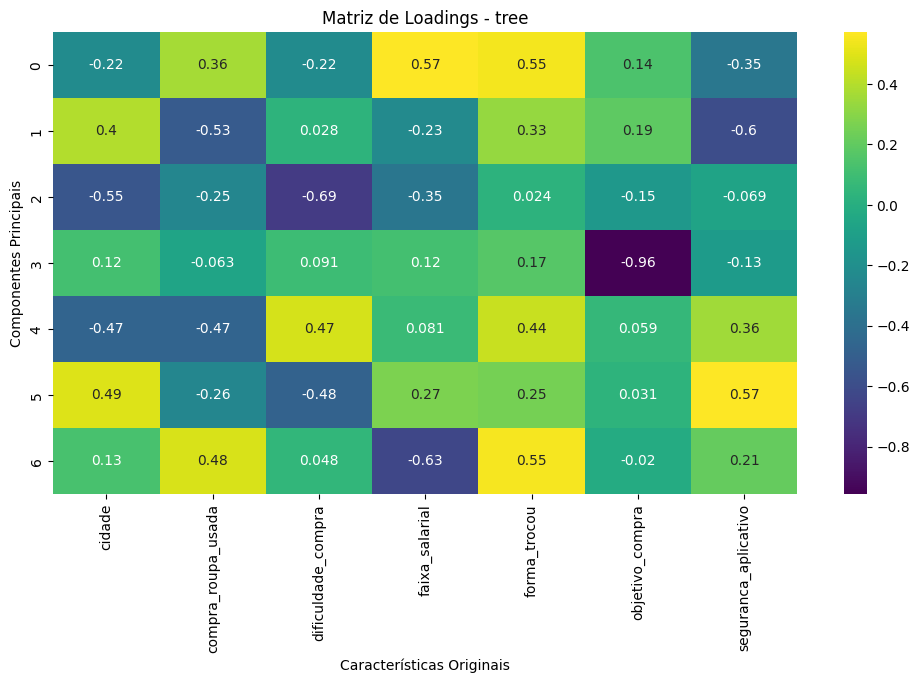

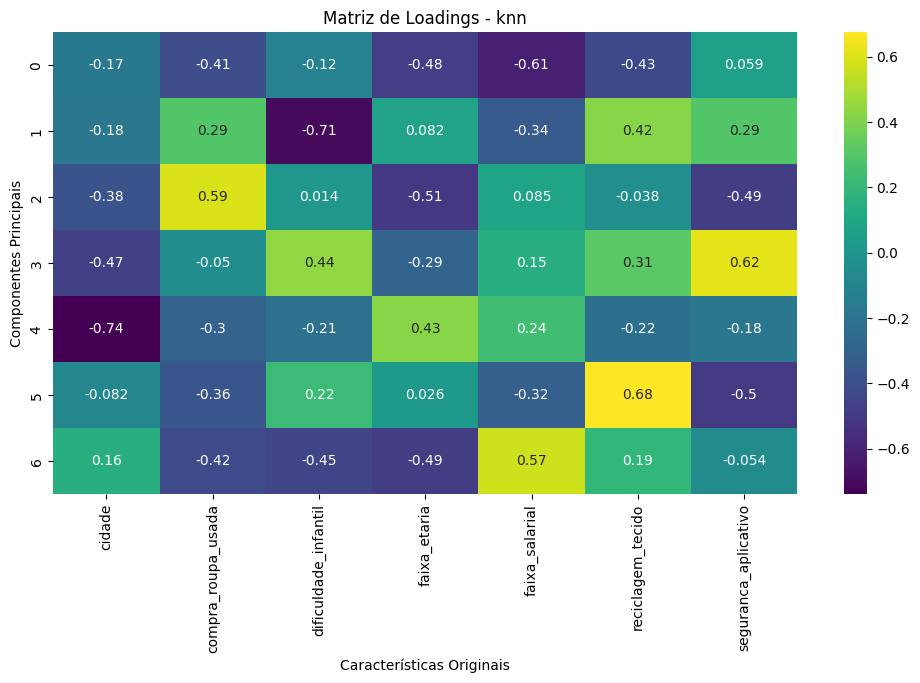

In [14]:
for i in parametros.keys():
    grid_pipe = GridSearchCV(estimator=pipeline, param_grid=parametros[i], scoring='f1', cv=5)

    X_train = modelos_armazenados[i][2][0]
    y_train = np.array(modelos_armazenados[i][2][1], copy=True)

    grid_pipe.fit(X_train, y_train)
    
    resultados = grid_pipe.cv_results_
    best_index = grid_pipe.best_index_

    infos_pipe[i] = {
        'pipeline': grid_pipe.best_estimator_,
        'params': grid_pipe.best_params_,
        'desvio_padrao': resultados['std_test_score'][best_index],
        'media_score': resultados['mean_test_score'][best_index],
        'media_score_etapa': [resultados[f'split{i}_test_score'][best_index] for i in range(grid_pipe.cv)]
    }

    pca = grid_pipe.best_estimator_.named_steps['pca']
    kBest = grid_pipe.best_estimator_.named_steps['SelectKBest']

    components_df = pd.DataFrame(pca.components_, columns=modelos_armazenados[i][4].columns[kBest.get_support(indices=True).tolist()])

    # Plotagem
    plt.figure(figsize=(12, 6))
    sns.heatmap(components_df, cmap='viridis', annot=True)
    plt.xlabel('Características Originais')
    plt.ylabel('Componentes Principais')
    plt.title(f'Matriz de Loadings - {i}')
    plt.show()

# Validação dos modelos

## Naive Bayes

### Treino e teste

In [15]:
tempo_naive = []
for i in range(0, 6):
    inicio = time.perf_counter()

    melhor_naive_pipe = infos_pipe['naive_bayes']['pipeline']
    melhor_naive_pipe.fit(modelos_armazenados['naive_bayes'][2][0], modelos_armazenados['naive_bayes'][2][1].values)

    y_pred_naive = melhor_naive_pipe.predict(modelos_armazenados['naive_bayes'][3][0])
    y_test_naive = modelos_armazenados['naive_bayes'][3][1]

    fim = time.perf_counter()

    tempo_naive.append(fim - inicio)

    # Metricas
    print(f"Reporte das Métricas que foram testadas {i}:\n", classification_report(y_test_naive, y_pred_naive))

    matriz_de_confusao = confusion_matrix(y_test_naive, y_pred_naive)
    print(matriz_de_confusao)

    sns.heatmap(matriz_de_confusao, square=True, annot=True, fmt='d', cbar=True,
                yticklabels=['yes','no'],
                xticklabels=['yes','no'])
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()
print(tempo_naive)

ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [ ]:
print(set(y_pred_naive))
print(set(y_test_naive))

{0, 1}
{0, 1}


## Tree

### Treino e teste

In [18]:
tempo_tree = []
for i in range(0, 6):
    inicio = time.perf_counter()

    melhor_tree_pipe = infos_pipe['tree']['pipeline']
    melhor_tree_pipe.fit(modelos_armazenados['tree'][2][0], modelos_armazenados['tree'][2][1].values)

    y_pred_tree = melhor_tree_pipe.predict(modelos_armazenados['tree'][3][0])
    y_val_tree = modelos_armazenados['tree'][3][1]

    fim = time.perf_counter()

    tempo_tree.append(fim - inicio)

    # Métricas
    print(f"Reporte das Métricas que foram testadas {i}:\n", classification_report(y_val_tree, y_pred_tree))

    matriz_de_confusao = confusion_matrix(y_val_tree, y_pred_tree)
    print(matriz_de_confusao)

    sns.heatmap(matriz_de_confusao, square=True, annot=True, fmt='d', cbar=True,
                yticklabels=['yes','no'],
                xticklabels=['yes','no'])
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()
print(tempo_tree)

ValueError: Classification metrics can't handle a mix of unknown and binary targets

## KNN

### Treino e teste

Reporte das Métricas que foram testadas 0:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.97        95

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204

[[106   3]
 [  2  93]]


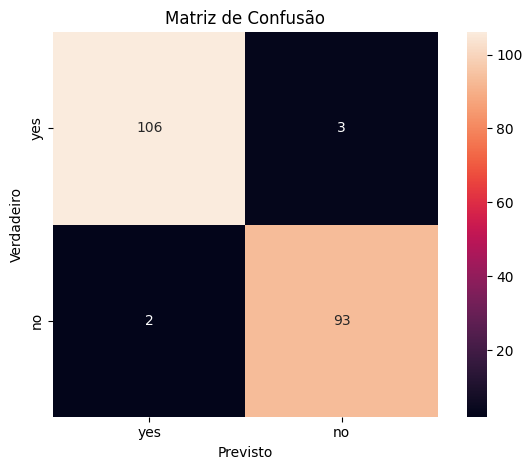

Reporte das Métricas que foram testadas 1:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.97        95

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204

[[106   3]
 [  2  93]]


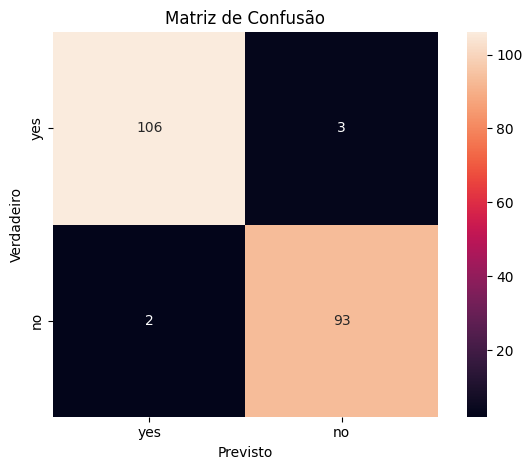

Reporte das Métricas que foram testadas 2:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.97        95

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204

[[106   3]
 [  2  93]]


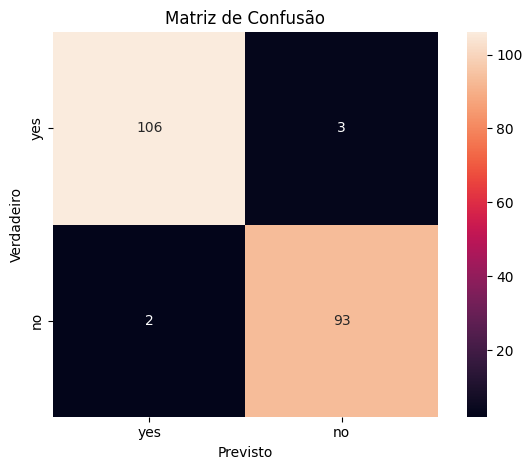

Reporte das Métricas que foram testadas 3:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.97        95

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204

[[106   3]
 [  2  93]]


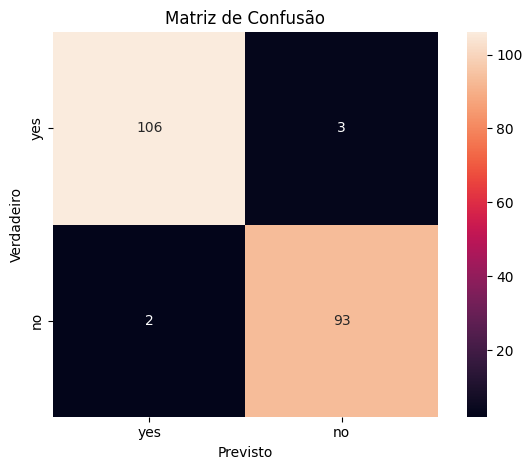

Reporte das Métricas que foram testadas 4:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.97        95

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204

[[106   3]
 [  2  93]]


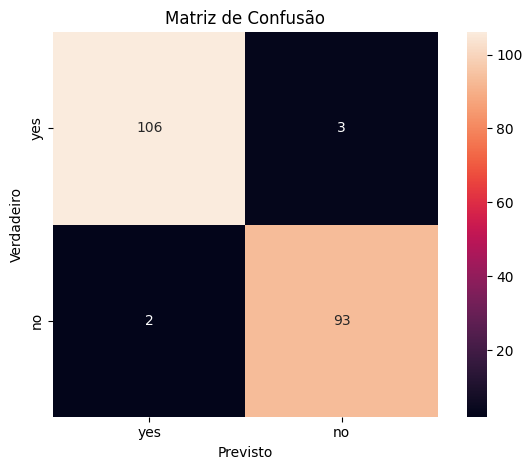

Reporte das Métricas que foram testadas 5:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.97        95

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204

[[106   3]
 [  2  93]]


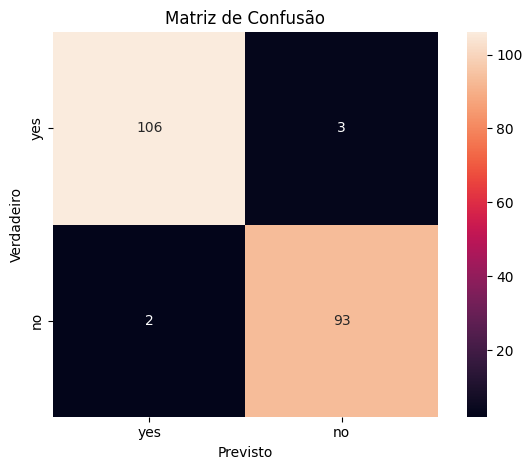

[0.014032500010216609, 0.009307899992563762, 0.011909900000318885, 0.007349399995291606, 0.011326499996357597, 0.009640200005378574]


In [ ]:
tempo_knn = []

for i in range(0, 6):
    inicio = time.perf_counter()

    melhor_knn_pipe = infos_pipe['knn']['pipeline']
    melhor_knn_pipe.fit(modelos_armazenados['knn'][2][0], modelos_armazenados['knn'][2][1].values)

    y_pred_knn = melhor_knn_pipe.predict(modelos_armazenados['knn'][3][0])
    y_val_knn = modelos_armazenados['knn'][3][1]

    fim = time.perf_counter()

    tempo_knn.append(fim - inicio)
    
    # Métricas
    print(f"Reporte das Métricas que foram testadas {i}:\n", classification_report(y_val_knn, y_pred_knn))

    matriz_de_confusao = confusion_matrix(y_val_knn, y_pred_knn)
    print(matriz_de_confusao)

    sns.heatmap(matriz_de_confusao, square=True, annot=True, fmt='d', cbar=True,
                yticklabels=['yes','no'],
                xticklabels=['yes','no'])
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()
print(tempo_knn)